# Tic-Tac-Toe Endgame Classifier

This notebook demonstrates how to build a machine learning model to predict whether a player ('x') has won a game of Tic-Tac-Toe based on the board configuration.

## 1. Imports
First, we import all the necessary libraries.
* **Pandas & NumPy**: For data manipulation.
* **Seaborn & Matplotlib**: For visualizing data and results (like the confusion matrix).
* **Scikit-Learn (sklearn)**: For machine learning tasks like splitting data, training the model, and evaluating metrics.
* **JSON & Pickle**: For saving the trained model and its parameters.

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import pickle
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## 2. Load and Inspect Data

Here we load the dataset.

**Important Improvement:** The original `tic-tac-toe.data` file does not have a header row (the first row is actual data, not column names). We use `header=None` to tell pandas this, and we manually provide the column names so we don't lose that first data point.

In [10]:
# Define column names manually since the file lacks a header
column_names = [
    'top-left-square', 'top-middle-square', 'top-right-square',
    'middle-left-square', 'middle-middle-square', 'middle-right-square',
    'bottom-left-square', 'bottom-middle-square', 'bottom-right-square',
    'class'
]

# Load the dataset
df = pd.read_csv('tic-tac-toe.data', names=column_names, header=None)

print(f"Dataset Shape: {df.shape}")
print("First 5 rows of the dataset:")
display(df.head())

Dataset Shape: (958, 10)
First 5 rows of the dataset:


,top-left-square,top-middle-square,top-right-square,middle-left-square,middle-middle-square,middle-right-square,bottom-left-square,bottom-middle-square,bottom-right-square,class
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive


## 3. Data Preprocessing

Machine learning models typically require numerical input. Our board data currently uses characters:
* `x` (Player X)
* `o` (Player O)
* `b` (Blank)

We will convert these into numbers:
* `x` -> `1`
* `o` -> `-1`
* `b` -> `0`

We also convert the target class (`positive`/`negative`) into `1` and `0`.

In [11]:
def preprocess_data(df):
    """Prepares the dataframe for training."""

    # 1. Separate Features (Board state) and Target (Win/Loss)
    X = df.iloc[:, :9]  # First 9 columns
    y = df.iloc[:, 9]   # Last column (class)

    # 2. Define mapping for board values
    board_mapping = {'x': 1, 'o': -1, 'b': 0}

    # 3. Apply mapping to features
    # Using apply + map to handle the transformation safely across all columns
    X_encoded = X.apply(lambda col: col.map(board_mapping))

    # 4. Encode labels: positive (win) = 1, negative (loss) = 0
    y_encoded = (y == 'positive').astype(int)

    # 5. Split into Training and Test sets
    # stratify=y_encoded ensures both sets have a similar ratio of wins/losses
    X_train, X_test, y_train, y_test = train_test_split(
        X_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )

    print(f"Training set size: {X_train.shape[0]}")
    print(f"Test set size: {X_test.shape[0]}")

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = preprocess_data(df)

Training set size: 766
Test set size: 192


## 4. Model Training

We will use **Logistic Regression**. Despite its name, it is a classification algorithm used to predict binary outcomes (1 or 0).

We will also save the model parameters (weights and bias) to a JSON file, which can be useful if you want to export the logic to another language (like C or JavaScript) later.

In [12]:
def train_model(X_train, X_test, y_train, y_test):
    print("\nTraining Logistic Regression Model...")

    # Initialize and train the model
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train, y_train)

    # Calculate Accuracy
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)

    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy:  {test_acc:.4f}")

    # Export parameters to JSON
    params = {
        'model_type': 'logistic_regression',
        'weights': model.coef_.tolist()[0], # Flatten the list
        'bias': model.intercept_.tolist()[0],
        'n_features': X_train.shape[1]
    }

    with open('logistic_regression_params.json', 'w') as f:
        json.dump(params, f, indent=2)

    # Save the full model object
    with open('logistic_regression_model.pkl', 'wb') as f:
        pickle.dump(model, f)

    print("Model parameters saved to 'logistic_regression_params.json'")

    return model

model = train_model(X_train, X_test, y_train, y_test)




Training Logistic Regression Model...
Train Accuracy: 0.9856
Test Accuracy:  0.9740
Model parameters saved to 'logistic_regression_params.json'


## 5. Calculation of Probability of Error

Calculate the **Probability of Error** for both the training and testing datasets manually.

**The Method:**
1. We compare the predicted outcome $\hat{y}_{m,1}$ with the real outcome $y_{m,1}$.
2. If they differ, we set $error_i = 1$.
3. If they are the same, we set $error_i = 0$.
4. We count the number of errors for the $N$ dataset.

**The Formula:**
$$ \text{probability of error} = \frac{1}{N} \sum_{i=1}^{N} error_i $$

In [13]:
def calculate_custom_prob_error(model, X, y_true, dataset_name="Data"):
    """
    Calculates probability of error based on the formula:
    Prob_Error = (1/N) * Sum(error_i)
    where error_i = 1 if prediction != actual else 0
    """
    # 1. Get Predictions
    y_pred = model.predict(X)

    # 2. Calculate N (Total number of samples)
    N = len(y_true)

    # 3. Calculate error_i for each sample
    # (y_true != y_pred) creates a boolean array (True if error, False if correct)
    # .astype(int) converts True to 1 and False to 0
    error_i_list = (y_true != y_pred).astype(int)

    # 4. Sum the errors
    total_errors = error_i_list.sum()

    # 5. Calculate Probability
    prob_error = (1 / N) * total_errors

    print(f"--- {dataset_name} Set Evaluation ---")
    print(f"Total Samples (N): {N}")
    print(f"Total Errors (Sum of error_i): {total_errors}")
    print(f"Probability of Error: {prob_error:.4f} (or {prob_error*100:.2f}%)")
    print("-" * 40)
    print("\n")

    return prob_error

# Calculate for Training Data
prob_error_train = calculate_custom_prob_error(model, X_train, y_train, "Training")

# Calculate for Testing Data
prob_error_test = calculate_custom_prob_error(model, X_test, y_test, "Testing")

--- Training Set Evaluation ---
Total Samples (N): 766
Total Errors (Sum of error_i): 11
Probability of Error: 0.0144 (or 1.44%)
----------------------------------------


--- Testing Set Evaluation ---
Total Samples (N): 192
Total Errors (Sum of error_i): 5
Probability of Error: 0.0260 (or 2.60%)
----------------------------------------




## 6. Confusion Matrix Evaluation

To visualize *where* the errors are happening (False Positives vs False Negatives), we use a Confusion Matrix using Seaborn.


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       265
           1       0.98      1.00      0.99       501

    accuracy                           0.99       766
   macro avg       0.99      0.98      0.98       766
weighted avg       0.99      0.99      0.99       766



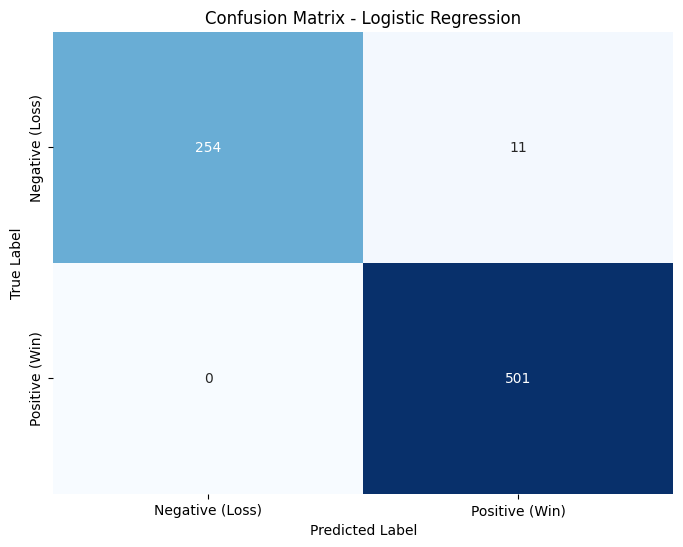

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        67
           1       0.96      1.00      0.98       125

    accuracy                           0.97       192
   macro avg       0.98      0.96      0.97       192
weighted avg       0.97      0.97      0.97       192



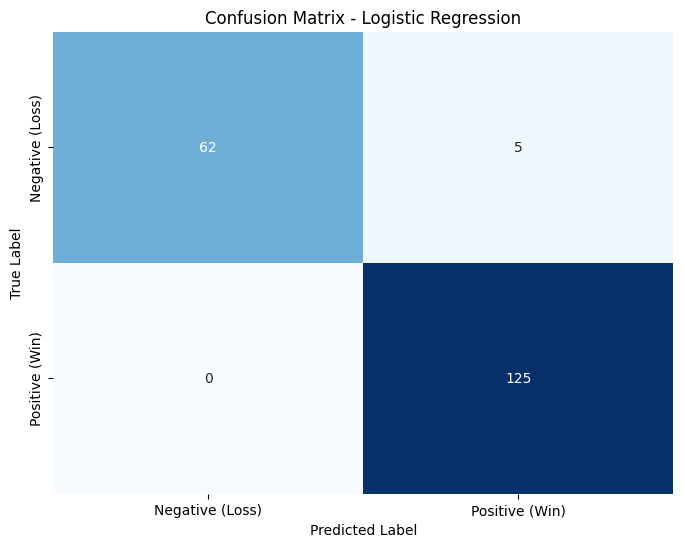

In [14]:
def plot_confusion_matrix(model, X_test, y_test):
    # Generate predictions
    y_pred = model.predict(X_test)

    # Create Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    # Text Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Negative (Loss)', 'Positive (Win)'],
                yticklabels=['Negative (Loss)', 'Positive (Win)'])

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix - Logistic Regression')
    plt.show()

plot_confusion_matrix(model, X_train, y_train)
plot_confusion_matrix(model, X_test, y_test)